In [1]:
import numpy as np
import tensorflow as tf
import uproot
import awkward as ak
import vector
import numba as nb
import os
import fnmatch
from dnn_tau import Dnn_tau
from kinematic import *
from utils import isolate_int, normalize
import pandas as pd
from numbers import Number
from utils import normalize, split_dataset, bucketize
from data_extractor import Data_extractor_v1
import matplotlib.pyplot as plt

In [2]:
path = "/data/hnl/prompt_tau/anatuple/nanoV10/TEST6/ttm_DeepTau2p5/"
extractor = Data_extractor_v1('ttm')
data = extractor(path)

In [4]:
N = len(data['event'])
n_bkg = N-sum([data['signal_label'][i] for i in range(len(data['signal_label']))])
data_norm = normalize(pd.DataFrame(data), 'mass_hyp', n_bkg)
data_norm = normalize(data_norm, 'signal_label', n_bkg)
print("Total background weight : ", sum(data_norm['genWeight'][i] for i in range(N) if data['signal_label'][i] == 0))
print("Total signal weight : ", sum(data_norm['genWeight'][i] for i in range(N) if data['signal_label'][i] == 1))
print("Number of background events : ", n_bkg)
data_norm = normalize(data_norm, 'channel', n_bkg)

Total background weight :  534759.9999999978
Total signal weight :  534760.0000000101
Number of background events :  534760.0


In [5]:
data_processed, channel_indices = bucketize(data_norm, 'channel')
print(list(data_processed.keys()))

['event', 'genWeight', 'deltaR_12', 'deltaR_13', 'deltaR_23', 'pt_123', 'mt_12', 'mt_13', 'mt_23', 'Mt_tot', 'n_tauh', 'mass_hyp', 'signal_label', 'channel', 'event_type']


In [6]:
input_vars = ['deltaR_13', 'deltaR_23', 'pt_123', 'mt_12', 'Mt_tot', 'channel', 'mass_hyp', 'signal_label']

In [33]:
model = Dnn_tau(input_vars)
model.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=7)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="./saved_models/checkpoint",
    monitor = "val_loss",
    save_best_only = True
)

In [8]:
train, val, test, meas = split_dataset(data_processed)
x_train = train[input_vars]
x_test = test[input_vars]
x_val = val[input_vars]
x_meas = meas[input_vars]

label_train = x_train.pop('signal_label').astype(float)
label_val = x_val.pop('signal_label').astype(float)
label_test = x_test.pop('signal_label').astype(float)
label_meas = x_meas.pop('signal_label').astype(float)

Total number of events :  613875
Train set : 37.55 %
Validation set : 12.52 %
Test set : 25.02 %
Measurement set : 24.91 %


In [35]:

history = model.fit(x_train, label_train, sample_weight=train['genWeight'], validation_data=(x_val, label_val), epochs=1000000, verbose=1, 
                    batch_size = 400, callbacks=[early_stopping, checkpoint])

Epoch 1/1000000
577/577 [==============================] - 4s 7ms/step - loss: 1.4598 - accuracy: 0.4979 - val_loss: 0.9634 - val_accuracy: 0.3921
INFO:tensorflow:Assets written to: ./saved_models/checkpoint/assets
Epoch 2/1000000
577/577 [==============================] - 4s 6ms/step - loss: 0.6283 - accuracy: 0.3536 - val_loss: 0.7925 - val_accuracy: 0.3550
INFO:tensorflow:Assets written to: ./saved_models/checkpoint/assets
Epoch 3/1000000
577/577 [==============================] - 4s 6ms/step - loss: 0.5010 - accuracy: 0.4663 - val_loss: 0.7242 - val_accuracy: 0.5206
INFO:tensorflow:Assets written to: ./saved_models/checkpoint/assets
Epoch 4/1000000
577/577 [==============================] - 4s 6ms/step - loss: 0.4302 - accuracy: 0.5341 - val_loss: 0.6944 - val_accuracy: 0.5420
INFO:tensorflow:Assets written to: ./saved_models/checkpoint/assets
Epoch 5/1000000
577/577 [==============================] - 4s 6ms/step - loss: 0.4019 - accuracy: 0.5540 - val_loss: 0.6786 - val_accuracy: 

In [9]:
model = tf.keras.models.load_model("./saved_models/checkpoint")

_, train_acc = model.evaluate(x_train, label_train, verbose=0)
_, test_acc = model.evaluate(x_test, label_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

2023-04-24 08:00:13.523173: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-24 08:00:14.368659: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6673 MB memory:  -> device: 0, name: Quadro RTX 4000, pci bus id: 0000:17:00.0, compute capability: 7.5
2023-04-24 08:00:14.369406: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6653 MB memory:  -> device: 1, name: Quadro RTX 4000, pci bus id: 0000:65:00.0, compute capability: 7.5


Train: 0.614, Test: 0.612


In [10]:
scores = model.predict(x_test)

In [12]:
output_test = pd.DataFrame({'scores': np.ravel(scores), 'genWeight': np.zeros(len(scores), dtype=np.float64)})
output_test['genWeight'] = test['genWeight']

In [33]:
def plot_hist(dataframe, keys, keys_label, bins_list, normalize = True, mode='n_tauh', return_counts = False):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    if type(dataframe) == dict:
        data_pd = pd.DataFrame(dataframe)
    else:
        data_pd = dataframe.copy()

    sub_df = {}
    if mode == 'n_tauh':
        sub_df_keys =  ["signal", "bkg_0", "bkg_1", "bkg_2"]
        event_type_labels = ["signal", r"$background\ 0\times\tau_h$", r"$background\ 1\times\tau_h$", r"$background\ 2\times\tau_h$"]
        signal = data_pd.loc[data_pd['signal_label']==1]
        background = data_pd.loc[data_pd['signal_label']==0]
        background_0 = background.loc[background['n_tauh']==0]
        background_1 = background.loc[background['n_tauh']==1]
        background_2 = background.loc[background['n_tauh']==2]
        sub_df[sub_df_keys[0]] = signal
        sub_df[sub_df_keys[1]] = background_0
        sub_df[sub_df_keys[2]] = background_1
        sub_df[sub_df_keys[3]] = background_2
    if mode == 'simple':
        sub_df_keys = ['Data']
        event_type_labels = [None]
        sub_df['Data'] = data_pd
    else:
        raise ValueError(f"The mode {mode} is not valid")
    
    figs = []
    counts = []

    if type(keys) != list:
        keys = [keys]
        keys_label = [keys_label]
        bins_list = [bins_list]
    
    for i,key in enumerate(keys):
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))

        # dictionary for counts/errors
        sub_dicts = []
        for i in range(len(list(sub_df.keys()))):
            sub_dicts.append({'counts':[], 'errors':[]})
        counts_j = dict(zip(list(sub_df.keys()), sub_dicts))

        for j,event_type in enumerate(sub_df.keys()):
            
            df = sub_df[event_type]
            
            if 'genWeight' not in list(df.keys()):
                df['genWeight'] = np.ones_like(df[list(df.keys())[0]])

            c,b = np.histogram(df[key], bins=bins_list[i], weights=df['genWeight'])
            c2,_ = np.histogram(df[key], bins=bins_list[i], weights=df['genWeight']**2)
            if normalize:
                norm = np.sum(c)
                c /= norm
                c2 /= norm**2
            error = np.sqrt(c2)

            counts_j[event_type]['counts'] = c
            counts_j[event_type]['errors'] = error
            
            if event_type_labels[j] != None:
                ax.stairs(c, b, label=event_type_labels[j], linewidth=2)
            else:
                ax.stairs(c, b, linewidth=2)
            # ax.errorbar((b[1:]+b[:-1])/2, c, yerr = np.sqrt(c2), marker = '.',drawstyle = 'steps-mid', color=colors[j])
            ax.errorbar((b[1:]+b[:-1])/2, c, yerr = error,fmt='.', color='k', linewidth=1)
            ax.set_xlabel(keys_label[i])
            if mode != 'simple':
                ax.legend()
            ax.grid(True)
        figs.append(fig)
        counts.append(counts_j)
    if return_counts:
        return figs, counts
    return figs

In [31]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update({"font.size": 16, "font.family": "serif"})
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

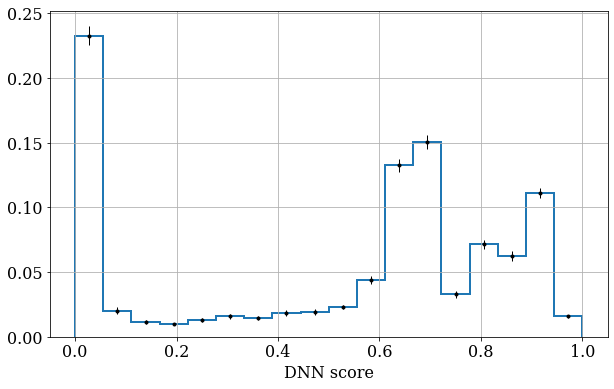

In [51]:
bins_list = np.linspace(0,1,19)
figs, counts = plot_hist(output_test, 'scores', 'DNN score', bins_list, normalize = True, mode='simple', return_counts=True)
figs[0].savefig("Images/TEST6_ttm_DeepTau2p5_score_hist.pdf")

In [50]:
bins_center = (bins_list[1:]+bins_list[:-1])/2
classed_bkg = (bins_center < 0.5)
values = counts[0]['Data']['counts']
percentage_bkg = values[classed_bkg].sum()/values.sum()
print(percentage_bkg)

0.355964152686866
